In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import datetime
from datetime import timedelta, datetime
from sklearn.cluster import MeanShift, KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import math
import requests
import io
import warnings
   

from matplotlib import pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore")

In [2]:
url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'

In [3]:
req = requests.get(url)
s = req.content
encoding = req.encoding

In [4]:
df = pd.read_csv(io.StringIO(s.decode(encoding)), sep=';', header=1)
df.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","12187,3","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","12351,46","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","101429,14","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","652569,48","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0379268748,RZD-23 CHF,RZD Capital PLC 23 CHF,Корпоративные еврооблигации,CH0379268748,NaN,NaN,"5000,0",CHF,90000.0,...,"0,0","398645,3","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0


In [5]:
# Оставим только рублевые облигации с заполненной ставкой купона и датой начала торгов
df = df[(df.FACEUNIT == 'RUB') & (df.COUPONPERCENT.notnull()) & (df.ISSUEDATE.notnull())].copy()
df.shape

(2067, 54)

In [6]:
# Преобразуем некоторые признаки в формат datetime
df['MATDATE']= pd.to_datetime(df['MATDATE'], format='%d.%m.%Y')
df['COUPONDATE']= pd.to_datetime(df['COUPONDATE'], format='%d.%m.%Y')
df['ISSUEDATE']= pd.to_datetime(df['ISSUEDATE'], format='%d.%m.%Y')
df['STARTDATEMOEX']= pd.to_datetime(df['STARTDATEMOEX'])
df['OFFERDATE']= pd.to_datetime(df['OFFERDATE'])

In [7]:
# Преобразуем числовые признаки в float
df['COUPONPERCENT'] = df['COUPONPERCENT'].str.replace(',', '.').astype(float)
df['FACEVALUE'] = df['FACEVALUE'].str.replace(',', '.').astype(float)
df['INITIALFACEVALUE'] = df['INITIALFACEVALUE'].str.replace(',', '.').astype(float)
df['COUPONVALUE'] = df['COUPONVALUE'].str.replace(',', '.').astype(float)
df['YIELDATWAP'] = df['YIELDATWAP'].str.replace(',', '.').astype(float)
df['PRICE'] = df['PRICE'].str.replace(',', '.').astype(float)
df['PRICE_RUB'] = df['PRICE_RUB'].str.replace(',', '.').astype(float)
df['RTL1'] = df['RTL1'].str.replace(',', '.').astype(float)
df['RTH1'] = df['RTH1'].str.replace(',', '.').astype(float)
df['RTL2'] = df['RTL2'].str.replace(',', '.').astype(float)
df['RTH2'] = df['RTH2'].str.replace(',', '.').astype(float)
df['RTL3'] = df['RTL3'].str.replace(',', '.').astype(float)
df['RTH3'] = df['RTH3'].str.replace(',', '.').astype(float)

In [8]:
# Установим дату погашения, равной дате оферты, если она указана. Если в итоге не определилась, установим в далеком будущем
df['MATDATE'] = df[['MATDATE','OFFERDATE']].apply(lambda x: x.MATDATE \
                            if (x.OFFERDATE is pd.NaT) | (x.OFFERDATE < datetime.now()) \
                            else x.OFFERDATE, axis=1)
df['MATDATE'] = df['MATDATE'].fillna(datetime(year=2100, month=12, day=31)) 
df['MATDATE']= pd.to_datetime(df['MATDATE'])

# Установим уровень листинга 3, где не указан
df['LISTLEVEL'] = df['LISTLEVEL'].fillna(3)  

# Посчитаем дюрацию как срок до погашения, где не указано
df['DURATION'] = df['DURATION'].fillna((df['MATDATE'] - datetime.now()).dt.days)  

# Оставим записи, где дюрация больше 0 и заполнено количество дней до погашения
df = df[(df.DURATION > 0) & (df.DAYSTOREDEMPTION.notnull())].copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 12 to 2655
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   2036 non-null   object        
 1   SHORTNAME               2036 non-null   object        
 2   NAME                    2036 non-null   object        
 3   TYPENAME                2036 non-null   object        
 4   ISIN                    2036 non-null   object        
 5   REGNUMBER               1971 non-null   object        
 6   LISTLEVEL               2036 non-null   float64       
 7   FACEVALUE               2036 non-null   float64       
 8   FACEUNIT                2036 non-null   object        
 9   ISSUESIZE               2036 non-null   float64       
 10  IS_COLLATERAL           2036 non-null   int64         
 11  IS_EXTERNAL             2036 non-null   int64         
 12  PRIMARY_BOARDID         2036 non-null   object 

## Задание 1.

### 1.	Оценить рынок рублевых облигаций по распределению купонной доходности

In [10]:
# Текущая дата

current_date = datetime.now()

In [11]:
df.shape

(2036, 54)

In [12]:
# Найдём выборочное среднее, дисперию, стандартное отклонение, медиану и моду.

mu = np.mean(df.COUPONPERCENT)
var = np.var(df.COUPONPERCENT)
std = np.std(df.COUPONPERCENT)
median = np.median(df.COUPONPERCENT)
moda = stats.mode(df.COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 6.8179
Дисперсия = 25.4711
Стандартное отклонение = 5.0469
Медиана = 7.5500
Мода = 0.0100


Видим очень большую дисперсию, также мода сильно отличается от среднего. Можем предположить, что в выборке присутствуют несколько процессов.

<AxesSubplot:xlabel='COUPONPERCENT', ylabel='Density'>

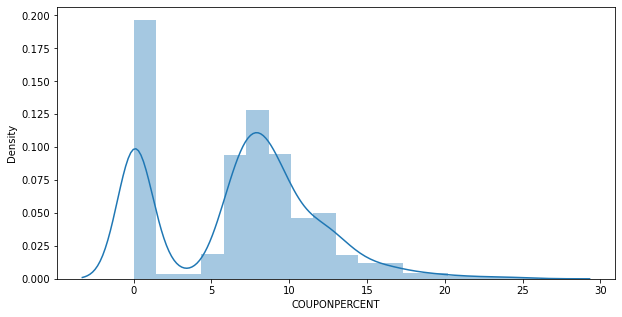

In [13]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df.COUPONPERCENT)

У распределения длинный хвост, попробуем прологарифмировать

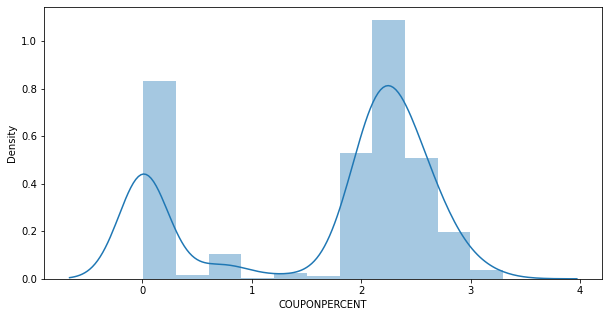

In [14]:
fig = plt.figure(figsize=(10, 5))

sns.distplot(np.log(df.COUPONPERCENT+1));

На графике видим два максимума. Значение ставки купона 0,01 сильно отличается от распределения остальных значений ставки. Посмотрим подробнее на наиболее часть встречающиеся значения ставки.

In [15]:
df.COUPONPERCENT.value_counts().head(10)

0.01     487
13.00     37
12.00     36
9.50      31
11.00     28
12.50     27
9.00      25
8.00      25
7.50      24
10.00     24
Name: COUPONPERCENT, dtype: int64

Видим, что действительно купонов со ставкой 0,01 на порядок больше, чем купонов с остальными ставками. Поищем, чем быть обусловлено.

[]

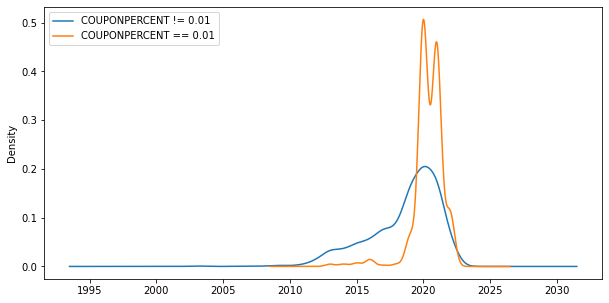

In [16]:
# Посмотрим, может зависит от даты выпуска
fig = plt.figure(figsize=(10, 5))

df[df.COUPONPERCENT != 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT != 0.01')
df[df.COUPONPERCENT == 0.01]['ISSUEDATE'].apply(lambda x: x.year).plot(kind='density', label='COUPONPERCENT == 0.01')

plt.legend()
plt.plot()

Явной зависимости от года выпуска не видим. Посмотрим зависимость от категориальных признаков.

In [17]:
# Введем флаг по COUPONPERCENT = 0.01
df['flag_001'] = df.COUPONPERCENT.apply(lambda x: 1 if x==0.01 else 0)

# Где частота купона и размер купона не указаны, поставим 0
df['COUPONFREQUENCY'] = df['COUPONFREQUENCY'].fillna(0)  
df['COUPONVALUE'] = df['COUPONVALUE'].fillna(0)

In [19]:
df[df.SECID == 'RU000A102LR1'] 

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001
1542,RU000A102LR1,ТомскАдм 8,Адм. г.Томск 34008,Муниципальные облигации,RU000A102LR1,RU34008TOM1,3.0,800.0,RUB,1000000.0,...,1541.9,"100,0",NaN,NaN,NaN,NaN,"10,00000","10,00000",1.0,0


In [20]:
cat_col = ['TYPENAME','LISTLEVEL','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY']

df[cat_col].isnull().sum()

TYPENAME           0
LISTLEVEL          0
IS_COLLATERAL      0
PRIMARY_BOARDID    0
HIGH_RISK          0
COUPONFREQUENCY    0
dtype: int64

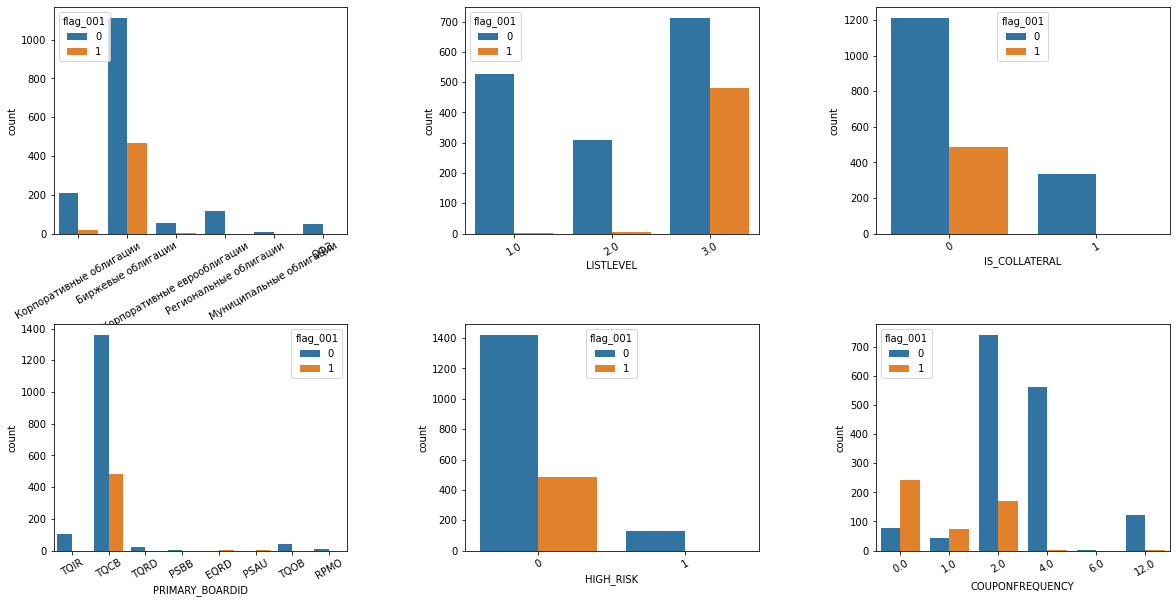

In [21]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(cat_col):
    plt.subplot(2,3,i+1)
    sns.countplot(x=df[col], hue=df['flag_001'])
    plt.xticks(rotation=30)

Видим, что облигации со ставкой купона 0.01% низкорисковые (HIGH_RISK=0), только в 3-ем уровне листинга и без обеспечения (LISTLEVEL=3, IS_COLLATERAL=0).

Посмотрим зависимость от числовых признаков.

In [22]:
num_col = ['FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION',\
           'PRICE','PRICE_RUB']

df[num_col].isnull().sum()

FACEVALUE           0
ISSUESIZE           0
DURATION            0
COUPONVALUE         0
COUPONLENGTH        1
INITIALFACEVALUE    0
DAYSTOREDEMPTION    0
PRICE               8
PRICE_RUB           8
dtype: int64

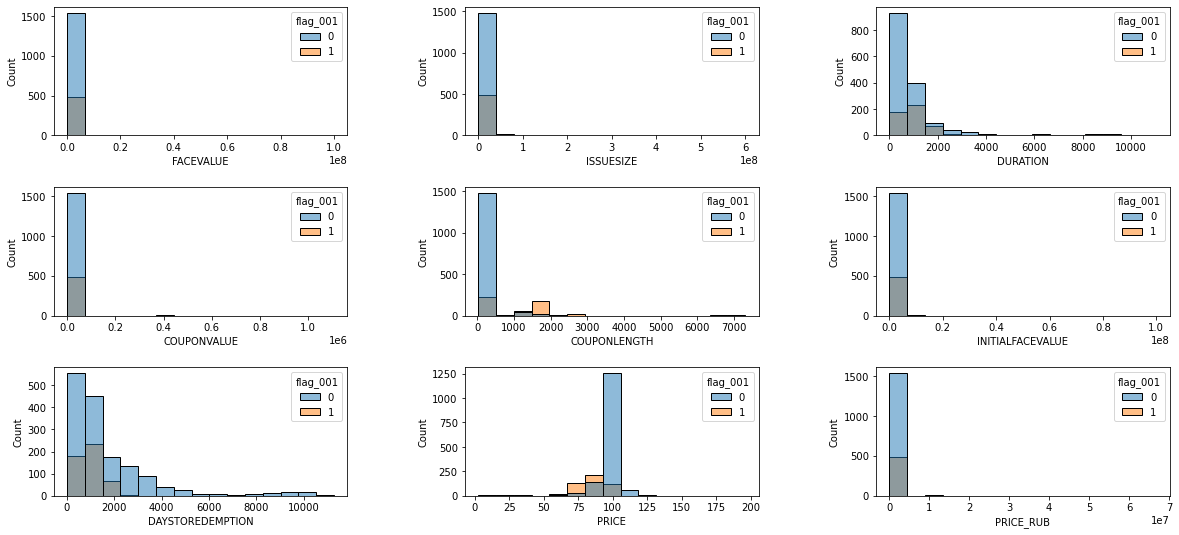

In [23]:
# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df, x=col, hue='flag_001', bins=15)

Видим, что у всех распределений длинные хвосты. Попробуем прологарифмировать.

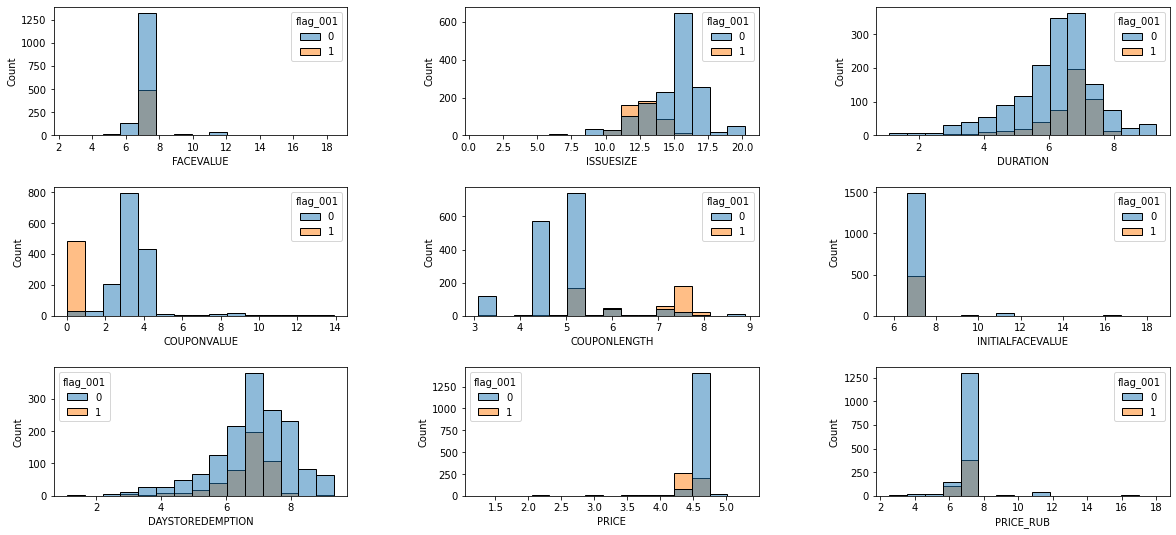

In [24]:
df_log = df[num_col + ['flag_001']].copy()
df_log[num_col] = df_log[num_col].apply(lambda x: np.log(x+1))

# Построим гистограммы числовых признаков с группировкой по новому флагу
fig = plt.figure(figsize=(20, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(num_col):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df_log, x=col, hue='flag_001', bins=15)

Видим, что у облигаций со ставкой купона 0.01% всегда маленькая сумма купона.

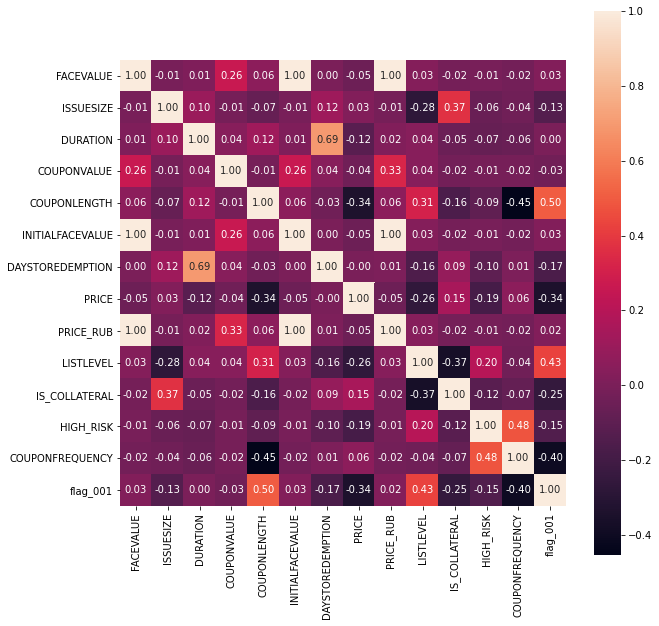

In [25]:
# Посмотрим на матрицу корреляций
plt.subplots(figsize=(10,10))
sns.heatmap(df[num_col + cat_col + ['flag_001']].corr(), fmt=".2f", annot=True, square=True)
plt.show()

Видим, что у введеного признака flag_001 достаточно сильная положительная корреляция с длиной купонного периода (COUPONLENGTH) и уровнем листинга (LISTLEVEL) и отрицательная корреляция с ценой в %% (PRICE) и частотой выплаты купона (COUPONFREQUENCY).

Исходя из анализа выше, будем считать, что облигации со ставкой купона 0.01% - это отдельная группа облигаций, выделим их в отдельный кластер и далее будем рассматривать датасет без них.

In [126]:
bonds_001 = df[df.flag_001 == 1].copy()
bonds = df[df.flag_001 != 1].copy()

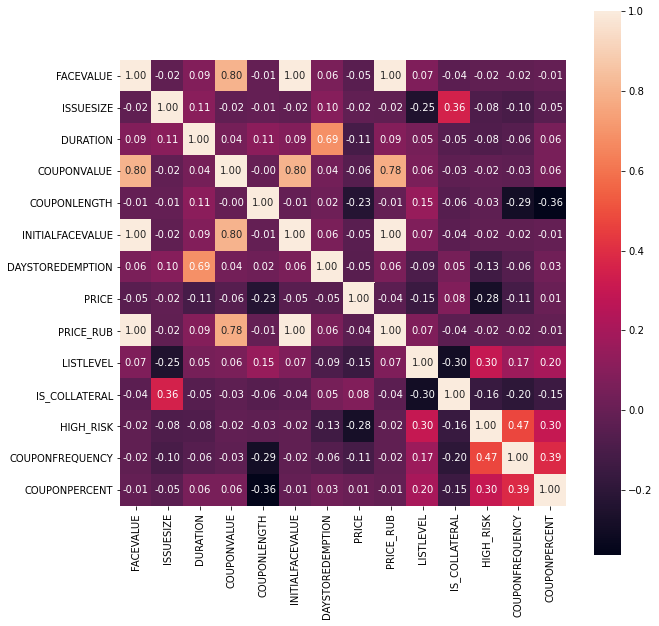

In [127]:
# Посмотрим на матрицу корреляций облигаций с flag_001 != 1
plt.subplots(figsize=(10,10))
sns.heatmap(bonds[num_col + cat_col + ['COUPONPERCENT']].corr(), fmt=".2f", annot=True, square=True)
plt.show()

Видим положительную зависимость купонного дохода (COUPONPERCENT) от частоты выплаты купона (COUPONFREQUENCY), уровня риска (HIGH_RISK) и уровня листинга (LISTLEVEL) и отрицательную зависимость от длины купонного периода (COUPONLENGTH) и наличия обеспечения (IS_COLLATERAL)

In [128]:
# Посмотрим на характеристики нового датасета.

mu = np.mean(bonds.COUPONPERCENT)
var = np.var(bonds.COUPONPERCENT)
std = np.std(bonds.COUPONPERCENT)
median = np.median(bonds.COUPONPERCENT)
moda = stats.mode(bonds.COUPONPERCENT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 8.9582
Дисперсия = 14.3265
Стандартное отклонение = 3.7850
Медиана = 8.5000
Мода = 13.0000


Дисперсия осталась большой, на графике видно, что длинные хвосты остались.

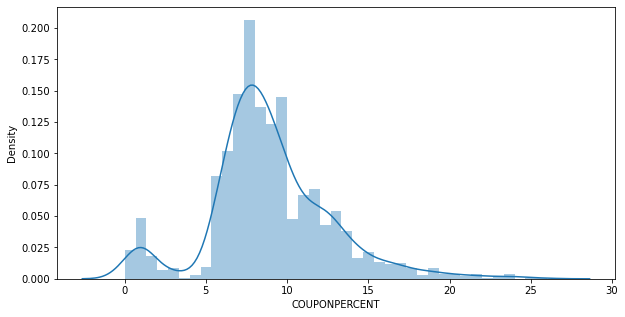

In [129]:
fig = plt.figure(figsize=(10, 5))

sns.distplot(bonds.COUPONPERCENT);

<AxesSubplot:>

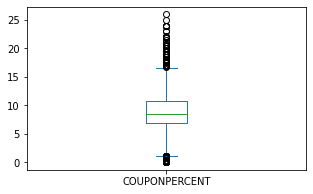

In [130]:
# Посмотрим на распределение на boxplot

bonds.COUPONPERCENT.plot(kind='box')

Видим очень много выбросов. Вожможно такие облигации также нужно выделить в отдельную группу.

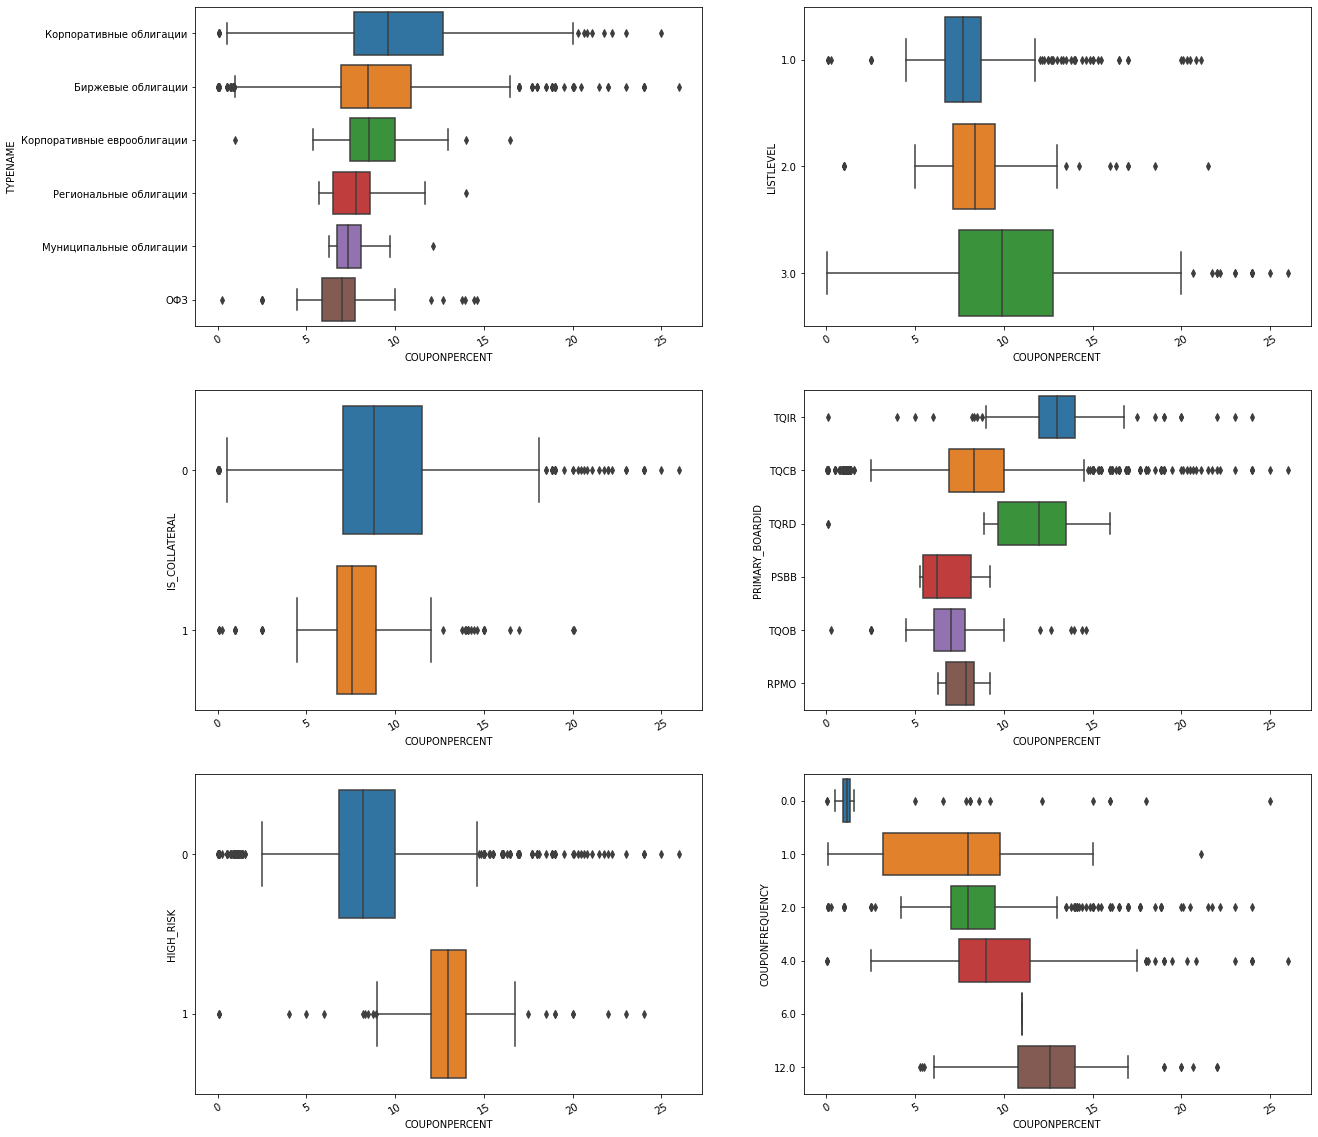

In [131]:
# Посмотрим на распределение на boxplot в зависимости от категориальных переменных

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, col in enumerate(cat_col):
    plt.subplot(3,2,i+1)
    sns.boxplot(y=col, x='COUPONPERCENT', data=bonds, orient="h")
    plt.xticks(rotation=30)

Выбросов по-прежнему очень много, но наблюдаются они не везде. Медианы в разрезе некоторых категориальных признаков почти не отличаются. Явные отличия медианы и разброса ставки мы видим у признаков:
1. Наличие обеспечения (IS_COLLATERAL)
2. Уровень риска (HIGH_RISK)
3. PRIMARY_BOARDID
4. Для уровня листинга (LISTLEVEL) есть различие между (1+2) и 3. В дальшейшем ввдем новый признак is_LISTLEVEL3 для обучения модели
5. Частота выплаты купона (COUPONFREQUENCY)

### 2. Предложить разделение на кластеры по купонной доходности. Предложить графическое представление полученных групп/кластеров. (график)

In [132]:
# Введем признак is_LISTLEVEL3
bonds['is_LISTLEVEL3'] = bonds['LISTLEVEL'].apply(lambda x: 1 if x==3 or np.isnan(x) else 0)

# Введем признак "Год выпуска"
bonds['ISSUE_year'] = bonds['ISSUEDATE'].apply(lambda x: x.year)

In [133]:
# Попробуем разделить облигации на кластеры с помощью метода k-Means

col_for_clasters = ['TYPENAME','is_LISTLEVEL3','IS_COLLATERAL','PRIMARY_BOARDID','HIGH_RISK','COUPONFREQUENCY','ISSUE_year',\
        'FACEVALUE','ISSUESIZE','DURATION','COUPONVALUE','COUPONLENGTH','INITIALFACEVALUE','DAYSTOREDEMPTION','PRICE',\
        'PRICE_RUB','COUPONPERCENT']

bonds = bonds[col_for_clasters]

# Удалим оставшиеся пропущенные значения
bonds = bonds.dropna()
bonds = bonds.reset_index()
bonds.head()

,index,TYPENAME,is_LISTLEVEL3,IS_COLLATERAL,PRIMARY_BOARDID,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,COUPONLENGTH,INITIALFACEVALUE,DAYSTOREDEMPTION,PRICE,PRICE_RUB,COUPONPERCENT
0,12,Корпоративные облигации,1,0,TQIR,1,0.0,2009,1000.0,40800.0,2428.0,1000.55,7304.0,1000.0,2429.0,100.00,1667.53,5.00
1,13,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,10000000.0,627.0,39.14,182.0,1000.0,666.0,99.62,1009.10,7.85
2,14,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,234.0,83.18,184.0,1000.0,246.0,102.37,1076.59,16.50
3,15,Корпоративные облигации,0,1,TQCB,0,2.0,2009,1000.0,7000000.0,1276.0,100.82,184.0,1000.0,2196.0,109.97,1197.23,20.00
4,16,Корпоративные облигации,0,1,TQCB,0,2.0,2010,1000.0,15000000.0,793.0,39.14,182.0,1000.0,858.0,99.68,1007.55,7.85


In [134]:
bonds.shape

(1542, 18)

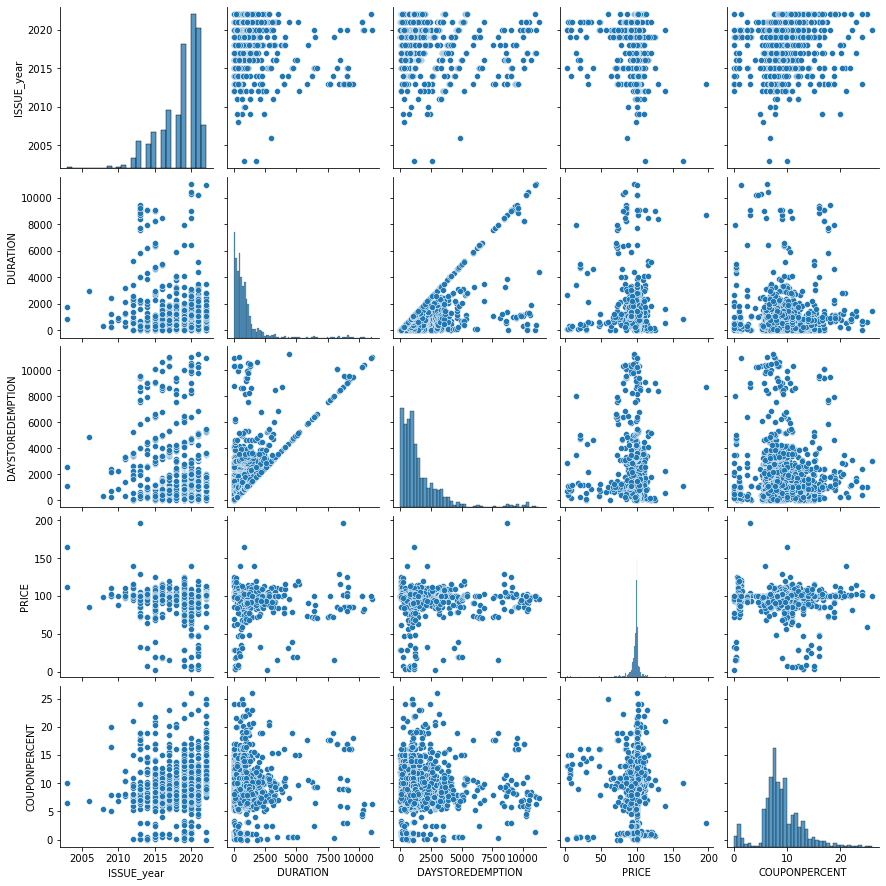

In [135]:
# Посмотрим на получившиеся данные визуально

sns.pairplot(bonds[['ISSUE_year','DURATION','DAYSTOREDEMPTION','PRICE','COUPONPERCENT']])

На графиках визуально видно разделение данных на области по некоторым признакам

In [136]:
# Закодируем некоторые категориальные переменные

bonds = pd.get_dummies(bonds, columns=['TYPENAME','PRIMARY_BOARDID'], prefix=['TN', 'PB'])
bonds.head(3)

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Корпоративные еврооблигации,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_RPMO,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD
0,12,1,0,1,0.0,2009,1000.0,40800.0,2428.0,1000.55,...,0,1,0,0,0,0,0,1,0,0
1,13,0,1,0,2.0,2009,1000.0,10000000.0,627.0,39.14,...,0,1,0,0,0,0,1,0,0,0
2,14,0,1,0,2.0,2009,1000.0,7000000.0,234.0,83.18,...,0,1,0,0,0,0,1,0,0,0


По методу локтя найдем оптимальное количество кластеров.

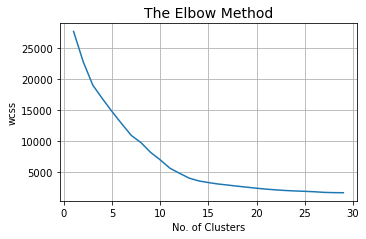

In [137]:
cols = ['COUPONLENGTH','PRICE','HIGH_RISK','COUPONFREQUENCY','is_LISTLEVEL3', 'IS_COLLATERAL','COUPONPERCENT',
        'TN_Биржевые облигации','TN_Корпоративные еврооблигации', 'TN_Корпоративные облигации',
        'TN_Муниципальные облигации', 'TN_ОФЗ', 'TN_Региональные облигации',
        'PB_RPMO', 'PB_TQCB', 'PB_TQIR', 'PB_TQOB', 'PB_TQRD']

#cols = bonds.columns[1:]

x = bonds.loc[:,cols]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

С большим количеством признаков оптимальное количество кластеров велико. Посмотрим, сильно ли уменьшится оптимальное количество кластеров, если использовать только один признак COUPONPERCENT

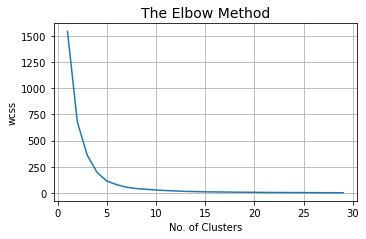

In [138]:
x = np.array(bonds.COUPONPERCENT).reshape(-1, 1)
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

Если использовать только один признак COUPONPERCENT, то оптимальное количество кластеров = 4

Обучим модель, используя только один признак COUPONPERCENT с гиперпараметром n_clusters = 4

In [139]:
#x = bonds.loc[:,cols]
x = np.array(bonds.COUPONPERCENT).reshape(-1, 1)
# Нормализуем данные
X = StandardScaler().fit_transform(x)

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

#bonds.insert(0, 'Cluster Labels', km.labels_)
bonds['Cluster_Labels'] = km.labels_
bonds.head()

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_RPMO,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD,Cluster_Labels
0,12,1,0,1,0.0,2009,1000.0,40800.0,2428.0,1000.55,...,1,0,0,0,0,0,1,0,0,0
1,13,0,1,0,2.0,2009,1000.0,10000000.0,627.0,39.14,...,1,0,0,0,0,1,0,0,0,0
2,14,0,1,0,2.0,2009,1000.0,7000000.0,234.0,83.18,...,1,0,0,0,0,1,0,0,0,3
3,15,0,1,0,2.0,2009,1000.0,7000000.0,1276.0,100.82,...,1,0,0,0,0,1,0,0,0,3
4,16,0,1,0,2.0,2010,1000.0,15000000.0,793.0,39.14,...,1,0,0,0,0,1,0,0,0,0


In [140]:
# Получились кластеры
bonds['Cluster_Labels'].value_counts()

0    939
1    409
2    111
3     83
Name: Cluster_Labels, dtype: int64

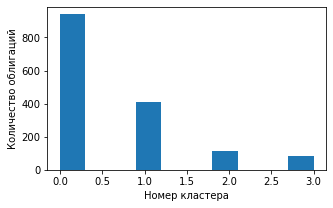

In [141]:
bonds['Cluster_Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [142]:
# Посмотрим статистические характеристики в разрезе кластеров

claster_groups = bonds.groupby('Cluster_Labels')
claster_groups.describe()['COUPONPERCENT']

,count,mean,std,min,25%,50%,75%,max
Cluster_Labels,,,,,,,,
0,939.0,7.721196,1.188538,4.490,6.8350,7.750,8.68,9.85
1,409.0,11.994685,1.442779,9.900,10.8000,12.000,13.00,15.00
2,111.0,1.215468,0.902319,0.016,0.8245,1.054,1.35,4.20
3,83.0,18.391108,2.604053,15.310,16.4050,17.690,20.00,26.00


Центры кластеров достаточно далеко друг от друга, стандартное отклонение не очень большое.

Построим графики распределения COUPONPERCENT по кластерам.

[]

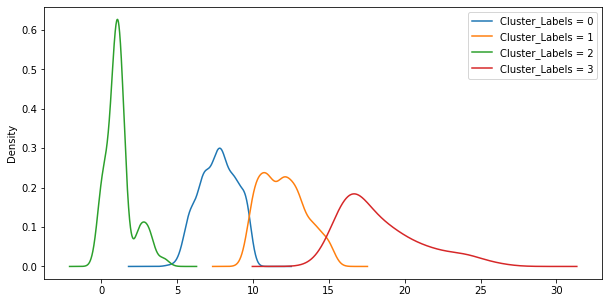

In [143]:
fig = plt.figure(figsize=(10, 5))

bonds[bonds.Cluster_Labels == 0]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 0')
bonds[bonds.Cluster_Labels == 1]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 1')
bonds[bonds.Cluster_Labels == 2]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 2')
bonds[bonds.Cluster_Labels == 3]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 3')

plt.legend()
plt.plot()

Посмотрим на графиках зависимость COUPONPERCENT от дюрации и частоты выплаты купонов.

Text(0.5, 1.0, 'MNIST. t-SNE projection')

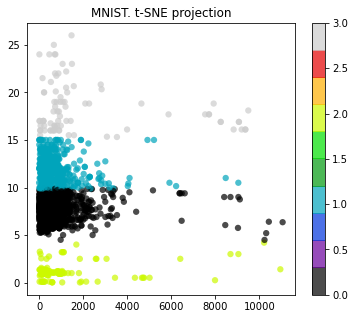

In [144]:
plt.figure(figsize=(6,5))
plt.scatter(bonds.DURATION, bonds.COUPONPERCENT, c=bonds['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

Text(0.5, 1.0, 'MNIST. t-SNE projection')

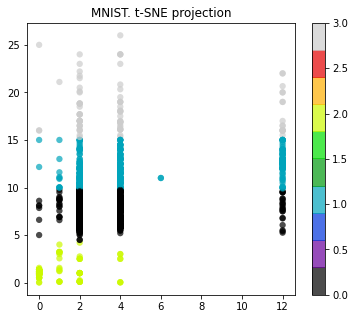

In [145]:
plt.figure(figsize=(6,5))
plt.scatter(bonds.COUPONFREQUENCY, bonds.COUPONPERCENT, c=bonds['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

На графиках видим четкое разделение на кластеры. Среди облигаций с высоким купонным доходом COUPONPERCENT преобладают облигации с маленькой дюрацией и частотой выплаты купона 2, 4 и 12. Разделим кластер с высоким годовым купонным доходом (Cluster_Labels = 3) на подкластеры с помощью метода k-Means.

In [146]:
bonds_3 = bonds[bonds['Cluster_Labels']==3].copy()

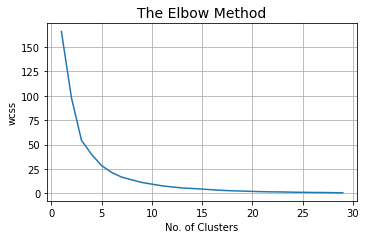

In [147]:
cols = ['PRICE','COUPONPERCENT']
#cols = bonds.columns[1:]

x = bonds_3.loc[:,cols]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

In [148]:
# Обучим модель с гиперпараметром n_clusters = 4

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

bonds_3['Cluster_Labels'] = km.labels_
bonds_3.head()

,index,is_LISTLEVEL3,IS_COLLATERAL,HIGH_RISK,COUPONFREQUENCY,ISSUE_year,FACEVALUE,ISSUESIZE,DURATION,COUPONVALUE,...,TN_Корпоративные облигации,TN_Муниципальные облигации,TN_ОФЗ,TN_Региональные облигации,PB_RPMO,PB_TQCB,PB_TQIR,PB_TQOB,PB_TQRD,Cluster_Labels
2,14,0,1,0,2.0,2009,1000.0,7000000.0,234.0,83.18,...,1,0,0,0,0,1,0,0,0,0
3,15,0,1,0,2.0,2009,1000.0,7000000.0,1276.0,100.82,...,1,0,0,0,0,1,0,0,0,1
22,35,0,0,0,1.0,2012,329.0,1900000.0,535.0,69.42,...,1,0,0,0,0,1,0,0,0,1
48,62,1,0,0,2.0,2013,1000.0,25000000.0,7534.0,88.21,...,0,0,0,0,0,1,0,0,0,3
49,63,1,0,0,4.0,2013,1000.0,10000000.0,9359.0,40.14,...,1,0,0,0,0,1,0,0,0,3


In [149]:
# Получились кластеры
bonds_3['Cluster_Labels'].value_counts()

0    40
1    22
3    17
2     4
Name: Cluster_Labels, dtype: int64

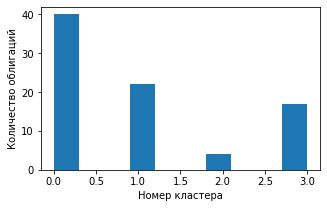

In [150]:
bonds_3['Cluster_Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [151]:
# Посмотрим статистические характеристики в разрезе кластеров

claster_groups = bonds_3.groupby('Cluster_Labels')
claster_groups.describe()['COUPONPERCENT']

,count,mean,std,min,25%,50%,75%,max
Cluster_Labels,,,,,,,,
0,40.0,17.130800,1.190608,15.31,16.2325,17.000,18.00,19.50
1,22.0,22.089545,1.796816,20.00,20.5400,21.875,23.75,26.00
2,4.0,16.000000,0.000000,16.00,16.0000,16.000,16.00,16.00
3,17.0,17.132941,1.081797,15.50,16.1000,16.900,17.69,18.83


[]

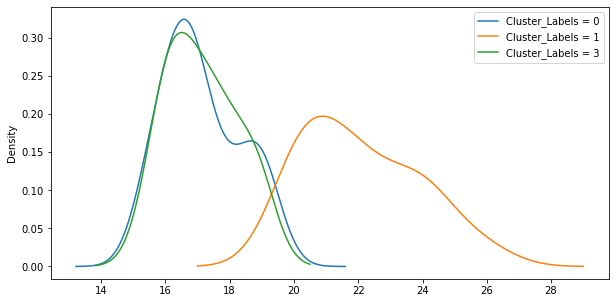

In [152]:
fig = plt.figure(figsize=(10, 5))

bonds_3[bonds_3.Cluster_Labels == 0]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 0')
bonds_3[bonds_3.Cluster_Labels == 1]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 1')
#bonds_3[bonds_3.Cluster_Labels == 2]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 2')
bonds_3[bonds_3.Cluster_Labels == 3]['COUPONPERCENT'].plot(kind='density', label='Cluster_Labels = 3')

plt.legend()
plt.plot()

Text(0.5, 1.0, 'MNIST. t-SNE projection')

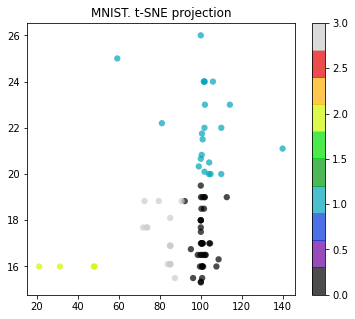

In [153]:
plt.figure(figsize=(6,5))
plt.scatter(bonds_3.PRICE, bonds_3.COUPONPERCENT, c=bonds_3['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection')

На графиках видно четкое разделение облигаций с высоким купонным доходом на кластеры. Отдельной группой выделяются высокодоходные облигации с маленькой ценой в %% (Cluster_Labels = 2). Это облигации:

In [154]:
df.loc[bonds_3[bonds_3.Cluster_Labels==2]['index']]

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001
1800,RU000A103DB0,ОткрБРСО3,Открытие Брокер СО-03,Корпоративные облигации,RU000A103DB0,6-02-01015-A,3.0,1000.0,RUB,295000.0,...,960.0,"100,0",NaN,NaN,NaN,NaN,"13,00000","10,00000",1.0,0
2025,RU000A104479,ОткрБРСО5,Открытие Брокер СО-05,Корпоративные облигации,RU000A104479,6-04-01015-A,3.0,1000.0,RUB,200000.0,...,955.0,"100,0",NaN,NaN,NaN,NaN,"13,00000","10,00000",1.0,0
2057,RU000A1047Z8,ОРГрупп2Р3,ОР ООО 002P-03,Биржевые облигации,RU000A1047Z8,4B02-03-00412-R-002P,3.0,1000.0,RUB,100000.0,...,419.8,"100,0",NaN,NaN,NaN,NaN,"15,00000","10,00000",1.0,0
2071,RU000A104A13,ОРГрупп2Р4,ОР ООО 002P-04,Биржевые облигации,RU000A104A13,4B02-04-00412-R-002P,3.0,1000.0,RUB,100000.0,...,647.0,"100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0,0


## Задание 2.

### По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям выпущенным в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей дата. (график и/или таблица). 

Сформируем новый датасет согласно условиям:

    1. Низкорисковые рублевые облигации 
    2. Облигации с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигации выпущенным в аналогичный период

In [194]:
df2 = df[(df.HIGH_RISK == 0) & (df.COUPONDAYSPASSED/df.COUPONLENGTH <= 0.2) & (df.COUPONDAYSPASSED>=0)].copy()

# Удалим записи, где не указана цена
df2 = df2[df2.PRICE.notnull()]

df2.shape

(315, 55)

#### Доходность будем считать по формуле<p>

$$ Profit =  \frac {( (Цена\_номинальная  – Цена\_покупки ) * (1 ЕСЛИ ≤0│0.87 ЕСЛИ>0)  –  НКД + 0.87 * Купонный\_доход\_руб * X\_лет) * 100% )}{( (Цена\_покупки+ НКД) * (1+Комиссия\_брокера\_в\_процентах/100 + Комиссия\_биржи/100) )} $$



In [195]:
# Введем признак "Количество дней до погашения", который будет равен:
# 1. 365 для облигаций со сроком погашения после "текущая дата + 365"
# 2. Количеству дней до MATDATE со сроком погашения до "текущая дата + 365" (ранее MATDATE обновили с учетом OFFERDATE)

df2['DAYS_TO_MATDATE'] = df2['MATDATE'].apply(lambda x: (x - current_date).days if (x - current_date).days <= 365 else 365)

# Посчитаем дельту цены облигации
df2['DELTA_PRICE'] = df2[['FACEVALUE','PRICE_RUB']].apply(lambda x: (x.FACEVALUE - x.PRICE_RUB) \
                                                         if (x.FACEVALUE - x.PRICE_RUB) <= 0 \
                                                         else 0.87*(x.FACEVALUE - x.PRICE_RUB), axis=1)

# Посчитаем НКД
df2['NKD'] = df2['COUPONVALUE']/df2['COUPONLENGTH'] * (df2['COUPONDAYSPASSED']+1)

# Посчитаем купонный доход на период год с текущей даты, учитывая новый признак "Количество дней до погашения"
df2['YEAR_COUPONVALUE'] = (df2['FACEVALUE'] * df2['COUPONPERCENT'] / 100) * (df2['DAYS_TO_MATDATE'] / 365)

# Комиссия брокера
broker_comm = 0.06 / 100

# Комиссия Биржи
exchange_comm = 0.0125 / 100

In [196]:
# Посчитаем доходность последующих купонов на период год с текущей даты

df2['PROFIT'] = (df2.DELTA_PRICE - df2.NKD + 0.87*df2.YEAR_COUPONVALUE) * 100 /  \
                ( (df2.PRICE_RUB + df2.NKD) * (1 + broker_comm + exchange_comm) )

df2.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT
24,RU000A0JS4J1,ЗСД 03,Запад.скор.диаметр АО об.03,Корпоративные облигации,RU000A0JS4J1,4-03-00350-D,1.0,1000.0,RUB,5000000.0,...,"35,0","10,00000","10,00000",0.0,0,365,-109.36,6.470769,98.400,-2.706582
25,RU000A0JS4K9,ЗСД 04,Запад.скор.диаметр АО об.04,Корпоративные облигации,RU000A0JS4K9,4-04-00350-D,1.0,1000.0,RUB,5000000.0,...,"37,0","31,00000","14,00000",0.0,0,365,-142.06,6.470769,98.400,-5.474575
26,RU000A0JS4L7,ЗСД 05,Запад.скор.диаметр АО об.05,Корпоративные облигации,RU000A0JS4L7,4-05-00350-D,1.0,1000.0,RUB,5000000.0,...,NaN,"10,00000","10,00000",1.0,0,365,-115.56,6.470769,98.400,-3.243795
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"16,0","10,00000","10,00000",0.0,0,365,-33.11,3.914286,109.900,5.645602
35,RU000A0JT593,ВолгСпорт2,Волга-Спорт АО обл. 02,Корпоративные облигации,RU000A0JT593,4-02-20468-P,1.0,329.0,RUB,1900000.0,...,NaN,"10,00000","10,00000",1.0,0,365,-133.15,2.282301,69.419,-16.145175


In [197]:
df2['PROFIT'].sort_values(ascending=False)

2282    475.194069
1943     68.262799
1777     59.430057
1737     57.723090
373      53.388029
           ...    
2411    -15.550467
35      -16.145175
78      -16.550051
2306    -34.465034
1880    -47.312765
Name: PROFIT, Length: 315, dtype: float64

In [217]:
# Выделим в отдельные группы облигации с отрицательной доходностью и доходностью больше 40%

df2['Cluster'] = 0

df2['Cluster'] = np.where(df2.PROFIT>40, 1, df2['Cluster'])
df2['Cluster'] = np.where(df2.PROFIT<0, 2, df2['Cluster'])

df3 = df2[df2['Cluster']==0].copy()
df3.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNTL0,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT,Cluster
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,365,-33.1100,3.914286,109.9,5.645602,0
55,RU000A0JTS06,Роснефть07,ПАО НК Роснефть обл.07,Корпоративные облигации,RU000A0JTS06,4-07-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,179,2.8710,0.600000,35.8,3.348319,0
56,RU000A0JTS22,Роснефть08,ПАО НК Роснефть обл.08,Корпоративные облигации,RU000A0JTS22,4-08-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000","10,00000",0.0,0,179,3.2190,0.600000,35.8,3.384546,0
63,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",Корпоративные облигации,RU000A0JTYJ6,4-23-65018-D,3.0,1000.0,RUB,10000000.0,...,"10,00000","10,00000",1.0,0,365,125.9325,6.175385,161.0,30.140611,0
64,RU000A0JTYK4,ФСК ЕЭС-28,"""ФСК ЕЭС""(ПАО)-обл. сер.28",Корпоративные облигации,RU000A0JTYK4,4-28-65018-D,3.0,1000.0,RUB,20000000.0,...,"10,00000","10,00000",1.0,0,365,125.9325,6.175385,161.0,30.140611,0


In [218]:
# Посмотрим на характеристики нового датасета.

mu = np.mean(df3.PROFIT)
var = np.var(df3.PROFIT)
std = np.std(df3.PROFIT)
median = np.median(df3.PROFIT)
moda = stats.mode(df3.PROFIT)[0][0]
print('Выборочное среднее = %.4f' % mu)
print('Дисперсия = %.4f' % var)
print('Стандартное отклонение = %.4f' % std)
print('Медиана = %.4f' % median)
print('Мода = %.4f' % moda)

Выборочное среднее = 10.6235
Дисперсия = 86.5379
Стандартное отклонение = 9.3026
Медиана = 7.6184
Мода = 0.0086


In [219]:
df3['PROFIT'].describe()

count    287.000000
mean      10.623486
std        9.318823
min        0.000898
25%        5.097759
50%        7.618404
75%       12.403116
max       39.438274
Name: PROFIT, dtype: float64

<AxesSubplot:xlabel='PROFIT', ylabel='Density'>

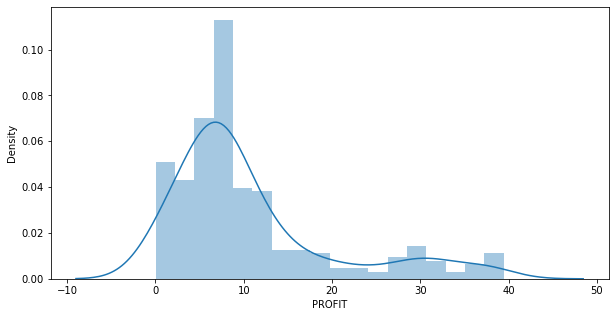

In [220]:
# Построим гистограмму и ядерную оценку плотности

fig = plt.figure(figsize=(10, 5))

sns.distplot(df3.PROFIT)

На графике видим длинный правый хвост

<AxesSubplot:>

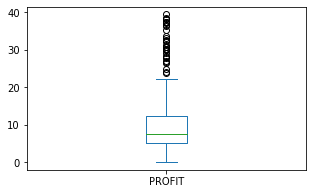

In [221]:
# Посмотрим на распределение на boxplot

df3.PROFIT.plot(kind='box')

Видим достаточно много выбросов. Попробуем разделить облигации на кластеры.

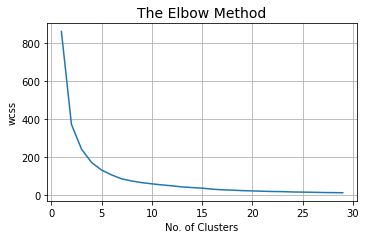

In [222]:
cols = ['PRICE','COUPONPERCENT','PROFIT']
#cols = bonds.columns[1:]

x = df3.loc[:,cols]
# Нормализуем данные
X = StandardScaler().fit_transform(x)

wcss = []
for i in range(1, 30):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = 0,
                algorithm = 'elkan',
                tol = 0.001)
    
    km.fit(X)
    labels = km.labels_
    wcss.append(km.inertia_)
    
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(range(1, 30), wcss)
plt.grid()
plt.tight_layout()
plt.title('The Elbow Method', fontsize = 14)
plt.xlabel('No. of Clusters', fontsize = 10)
plt.ylabel('wcss', fontsize = 10)
plt.show()

In [223]:
# Обучим модель с гиперпараметром n_clusters = 4

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(X)

df3['Cluster_Labels'] = km.labels_
df3.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,DISCOUNTH0,FULLCOVERED,flag_001,DAYS_TO_MATDATE,DELTA_PRICE,NKD,YEAR_COUPONVALUE,PROFIT,Cluster,Cluster_Labels
27,RU000A0JS4Z7,ВЭБ.РФ 21,ВЭБ.РФ об. сер. 21,Корпоративные облигации,RU000A0JS4Z7,4-26-00004-T,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,365,-33.1100,3.914286,109.9,5.645602,0,0
55,RU000A0JTS06,Роснефть07,ПАО НК Роснефть обл.07,Корпоративные облигации,RU000A0JTS06,4-07-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,179,2.8710,0.600000,35.8,3.348319,0,0
56,RU000A0JTS22,Роснефть08,ПАО НК Роснефть обл.08,Корпоративные облигации,RU000A0JTS22,4-08-00122-A,1.0,1000.0,RUB,15000000.0,...,"10,00000",0.0,0,179,3.2190,0.600000,35.8,3.384546,0,0
63,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",Корпоративные облигации,RU000A0JTYJ6,4-23-65018-D,3.0,1000.0,RUB,10000000.0,...,"10,00000",1.0,0,365,125.9325,6.175385,161.0,30.140611,0,2
64,RU000A0JTYK4,ФСК ЕЭС-28,"""ФСК ЕЭС""(ПАО)-обл. сер.28",Корпоративные облигации,RU000A0JTYK4,4-28-65018-D,3.0,1000.0,RUB,20000000.0,...,"10,00000",1.0,0,365,125.9325,6.175385,161.0,30.140611,0,2


In [224]:
# Получились кластеры
df3['Cluster_Labels'].value_counts()

0    196
3     41
1     37
2     13
Name: Cluster_Labels, dtype: int64

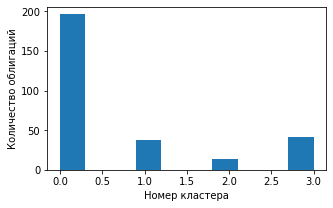

In [225]:
df3['Cluster_Labels'].plot(kind='hist')

plt.ylabel('Количество облигаций')
plt.xlabel('Номер кластера') 
plt.show()

In [226]:
# Посмотрим статистические характеристики в разрезе кластеров

claster_groups = df3.groupby('Cluster_Labels')
claster_groups.describe()['PROFIT']

,count,mean,std,min,25%,50%,75%,max
Cluster_Labels,,,,,,,,
0,196.0,7.397489,3.554378,0.354311,5.210625,7.184819,9.153126,17.513116
1,37.0,29.276050,6.574816,17.839813,24.121976,29.783378,35.105834,39.438274
2,13.0,25.949942,6.920152,17.255502,19.571020,30.140611,30.662010,36.963892
3,41.0,4.352914,4.072356,0.000898,0.008557,3.648879,7.649359,14.242870


[]

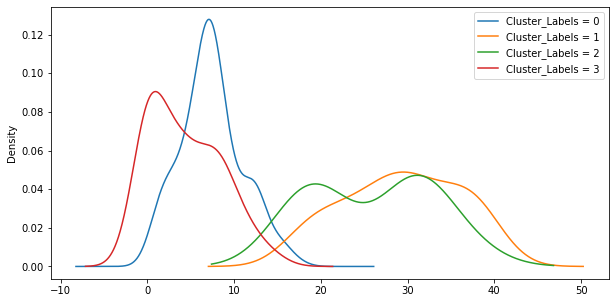

In [227]:
fig = plt.figure(figsize=(10, 5))

df3[df3.Cluster_Labels == 0]['PROFIT'].plot(kind='density', label='Cluster_Labels = 0')
df3[df3.Cluster_Labels == 1]['PROFIT'].plot(kind='density', label='Cluster_Labels = 1')
df3[df3.Cluster_Labels == 2]['PROFIT'].plot(kind='density', label='Cluster_Labels = 2')
df3[df3.Cluster_Labels == 3]['PROFIT'].plot(kind='density', label='Cluster_Labels = 3')

plt.legend()
plt.plot()

На графике видим, что доходность облигаций сопоставима попарно по кластерам:
- 0-ой и 3-ий
- 1-ый и 2-ой

Попробуем найти признак, который обуславливает это разделение на кластеры

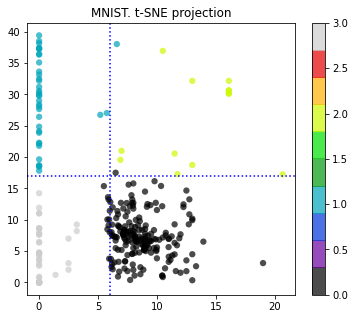

In [239]:
plt.figure(figsize=(6,5))

#fig, ax = plt.subplots()
plt.scatter(df3.COUPONPERCENT, df3.PROFIT, c=df3['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

#ax.vlines(4, -1, 41)
plt.axhline(y = 17, color = 'b', linestyle = ':')
plt.axvline(x = 6, color = 'b', linestyle = ':')
plt.colorbar()
plt.title('MNIST. t-SNE projection')
plt.show()

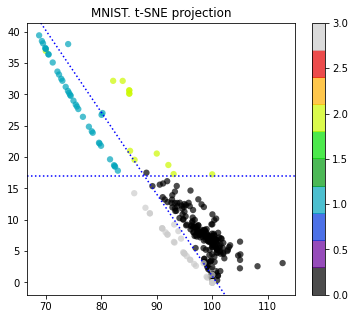

In [251]:
plt.figure(figsize=(6,5))
plt.scatter(df3.PRICE, df3.PROFIT, c=df3['Cluster_Labels'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.axline((74, 35), (100, 1), color='b', linestyle = ':')
plt.axhline(y = 17, color = 'b', linestyle = ':')

plt.colorbar()
plt.title('MNIST. t-SNE projection')
plt.show()

На графиках видим четкое разделение:

    1. Доходность ниже 17% с маленьким купонным доходом (от 0% до 5%)
    2. Доходность ниже 17% с высоким купонным доходом (от 5% до 20%)
    3. Доходность выше 17% с маленьким купонным доходом (от 0% до 5%)
    4. Доходность выше 17% с высоким купонным доходом (от 5% до 20%)